In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import cv2
import time
import copy
import shutil 
import zipfile
from torchvision import transforms, models
from tqdm import tqdm

In [2]:
class MyRemoveBackground:
    """Remove images background.
    """
    
    def __init__(self):
        pass

    def __call__(self, in_img):
        
        # Convert PIL image to numpy array
        in_img = np.array(in_img)
        
        # Get the height and width from OpenCV image
        height, width = in_img.shape[:2]
        
        # Create a mask holder
        mask = np.zeros([height, width], np.uint8)

        # Grab Cut the object
        bgdModel = np.zeros((1, 65),np.float64)
        fgdModel = np.zeros((1, 65),np.float64)

        # Hard Coding the Rect The object must lie within this rect.
        rect = (15, 15, width-30, height-30)
        cv2.grabCut(in_img, mask, rect, bgdModel, fgdModel, 10, cv2.GC_INIT_WITH_RECT)
        mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
        out_img = in_img * mask[:, :, np.newaxis]

        # Get the background
        background = in_img - out_img

        # Change all pixels in the background that are not black to white
        background[np.where((background > [0, 0, 0]).all(axis = 2))] = [255, 255, 255]

        #Add the background and the image
        out_img = background + out_img

        return transforms.functional.to_pil_image(out_img)
    

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [6]:
def unzip_data(zip_file, destination_dir):
    """Extract pictures from zip file.
    """
    print('Data extraction started...', end='')
    with zipfile.ZipFile(zip_file, 'r') as zip_obj:
        zip_obj.extractall(destination_dir)
    print('done.')
    print(f'Files unzipped to \'{destination_dir}\'\n')

def remove_background(image_roots):
    """Remove picture background.
       This function use MyRemoveBackground class.
    """
    remove_photo_background = MyRemoveBackground()

    print('Backgrounds removing started...')
    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        
        print(f'{len(files)} pictures was found in {path}', end='')
        for i, file in enumerate(files):
            img_original = cv2.imread(path + file)
            img_cleaned = remove_photo_background(img_original)
            img_cleaned = np.array(img_cleaned)
            cv2.imwrite(path + file, img_cleaned)
            if i % 20 == 0:
                print('\n{:>3d}/{:>3d}'.format(i, len(files)), end='')
            print('.', end='')
        print()
    print('Backgrounds removing is complete.\n')
    
def make_extra_images(image_roots):
    """Function will make extra pictures with horizontal and vertical reflection.
    """

    print('Extra pictures generation started...', end='')
    prefix_names = ['_090', '_180', '_270']

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg') and '_' not in x, files))

        for i, file in enumerate(files):
            img = cv2.imread(path + file)
            # Make extra pictures: flip each of originals photo to 90, 180 and 270 degrees
            for i, angle in enumerate([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]):
                img = cv2.rotate(img, angle)
                img_name = path + file[:file.find('.')] + prefix_names[i] + file[file.find('.'):]
                if not os.path.exists(img_name):
                    cv2.imwrite(img_name, img)
    print('done.')

    for path in image_roots:
        files = os.listdir(path)
        files = list(filter(lambda x: x.endswith('.jpg'), files))
        print(f'{len(files)} pictures added to \'{path}\'')
    print()

In [7]:
class_names = ['cleaned', 'dirty']
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Extract images (Kaggle enviropment)
data_root = 'plates/'
unzip_data(zip_file='plates.zip', destination_dir='')

# Remove images background 
remove_background(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/'),
                               os.path.join(data_root, 'test/')])

# Create extra images for training models
make_extra_images(image_roots=[os.path.join(data_root, train_dir, 'cleaned/'),
                               os.path.join(data_root, train_dir, 'dirty/')])

Data extraction started...done.
Files unzipped to ''

Backgrounds removing started...
20 pictures was found in plates/train/cleaned/
  0/ 20....................
20 pictures was found in plates/train/dirty/
  0/ 20....................
744 pictures was found in plates/test/
  0/744....................
 20/744....................
 40/744....................
 60/744....................
 80/744....................
100/744....................
120/744....................
140/744....................
160/744....................
180/744....................
200/744....................
220/744....................
240/744....................
260/744....................
280/744....................
300/744....................
320/744....................
340/744....................
360/744....................
380/744....................
400/744....................
420/744....................
440/744....................
460/744....................
480/744....................
500/744....................

In [11]:
# Copy images to train, valid and test dir
for dir_name in [train_dir, valid_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(valid_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

100%|██████████| 81/81 [00:00<00:00, 6400.74it/s]


'test/unknown'

In [48]:
# Transformations methods
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.1, interpolation=3, fill=255),
        transforms.RandomChoice([transforms.CenterCrop(180),
                                 transforms.CenterCrop(160),
                                 transforms.CenterCrop(140),
                                 transforms.CenterCrop(120),
                                 transforms.Compose([transforms.CenterCrop(280),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 transforms.Compose([transforms.CenterCrop(200),
                                                     transforms.Grayscale(3),
                                                     ]),
                                 ]),
        transforms.Resize((224, 224)),
        transforms.ColorJitter(hue=(0.1, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),}

# Datasets
dataset = {
    'train': torchvision.datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': torchvision.datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid']),
    'test': ImageFolderWithPaths('test', transform=image_transforms['valid']),
}
 
# Dataloaders
batch_size = 4
train_dataloader = torch.utils.data.DataLoader(dataset['train'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

valid_dataloader = torch.utils.data.DataLoader(dataset['valid'],
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=batch_size)

test_dataloader  = torch.utils.data.DataLoader(dataset['test'],
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

# Mini report of loaded data
print('Train, Valid and Test datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_dataloader), len(dataset['train'])))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_dataloader), len(dataset['valid'])))
print('{:<7s}{:>10d}{:>10d}'.format('Test',  len(test_dataloader),  len(dataset['test'])))
                            

Train, Valid and Test datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train          33       132
Valid           7        28
Test          744       744


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:772: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


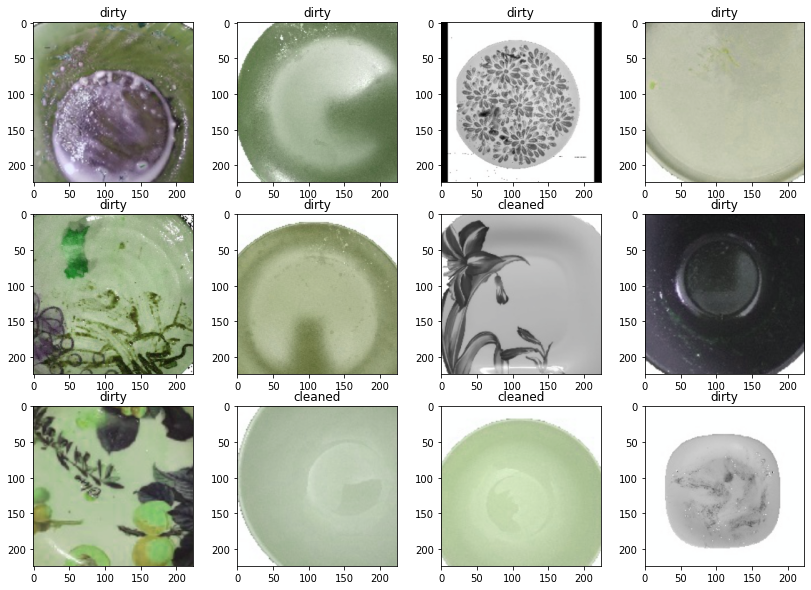

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)

image_iter = iter(train_dataloader)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(3):
    X_batch, y_batch = next(image_iter)
    for j in range(0, len(X_batch)):
        plt.subplot(3, batch_size, i*batch_size + j + 1)
        plt.title(class_names[y_batch[j].item()])
        plt.imshow(X_batch[j].permute(1, 2, 0).numpy() * std + mean)

In [50]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    print('{:<7s}|{:^20s}|{:^20s}|'.format('', 'Train', 'Valid'))
    print('{:<7s}|{:>10s}{:>10s}|{:>10s}{:>10s}|'.format('Epoch', 'Loss', 'Acc', 'Loss', 'Acc'))
    print('-' * 50)

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = valid_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                print('{:>3d}/{:>3d}|{:>10.4f}{:>10.4f}|'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc), end='')
            else:
                print('{:>10.4f}{:>10.4f}|'.format(epoch_loss, epoch_acc))

    return model

In [63]:
class PlatesNet(torch.nn.Module):
    def __init__(self):
        super(PlatesNet, self).__init__()
        self.net = models.resnet50(pretrained=True)
        
        # Disable grad for all conv layers
        for param in self.net.parameters():
            param.requires_grad = False                
        
        # Create some additional layers for ResNet model
        fc_inputs = self.net.fc.in_features
        self.net.fc = torch.nn.Sequential(
            torch.nn.Linear(fc_inputs, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.Sigmoid(),
            torch.nn.Dropout(0, 2),
            torch.nn.Linear(128, 2),
            # nn.LogSoftmax(dim=1) # For using NLLLoss()
        )  
    def forward(self, x):
        x = self.net(x)
        return x

In [64]:
import random
seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

model = PlatesNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [65]:
train_model(model, loss, optimizer, scheduler, num_epochs=35)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


       |       Train        |       Valid        |
Epoch  |      Loss       Acc|      Loss       Acc|
--------------------------------------------------


  0%|          | 0/33 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 33/33 [00:01<00:00, 20.49it/s]


  1/ 35|    0.7266    0.4621|

100%|██████████| 7/7 [00:00<00:00, 11.56it/s]


    0.6819    0.6786|


100%|██████████| 33/33 [00:01<00:00, 20.60it/s]


  2/ 35|    0.6948    0.5379|

100%|██████████| 7/7 [00:00<00:00, 11.98it/s]


    0.6740    0.6429|


100%|██████████| 33/33 [00:01<00:00, 21.51it/s]


  3/ 35|    0.6692    0.5909|

100%|██████████| 7/7 [00:00<00:00, 11.77it/s]


    0.6761    0.5000|


100%|██████████| 33/33 [00:01<00:00, 21.60it/s]


  4/ 35|    0.6053    0.7197|

100%|██████████| 7/7 [00:00<00:00, 11.82it/s]


    0.5198    0.8214|


100%|██████████| 33/33 [00:01<00:00, 21.32it/s]


  5/ 35|    0.5764    0.6970|

100%|██████████| 7/7 [00:00<00:00, 11.36it/s]


    0.4375    0.8214|


100%|██████████| 33/33 [00:01<00:00, 21.59it/s]


  6/ 35|    0.4887    0.7727|

100%|██████████| 7/7 [00:00<00:00, 12.16it/s]


    0.3438    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.19it/s]


  7/ 35|    0.4177    0.8106|

100%|██████████| 7/7 [00:00<00:00, 11.96it/s]


    0.3896    0.8214|


100%|██████████| 33/33 [00:01<00:00, 21.83it/s]


  8/ 35|    0.3672    0.8712|

100%|██████████| 7/7 [00:00<00:00, 12.27it/s]


    0.3125    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.81it/s]


  9/ 35|    0.4089    0.8258|

100%|██████████| 7/7 [00:00<00:00, 11.89it/s]


    0.3202    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.56it/s]


 10/ 35|    0.4454    0.7879|

100%|██████████| 7/7 [00:00<00:00, 11.85it/s]


    0.3941    0.7500|


100%|██████████| 33/33 [00:01<00:00, 21.69it/s]


 11/ 35|    0.3861    0.8561|

100%|██████████| 7/7 [00:00<00:00, 12.19it/s]


    0.3445    0.8571|


100%|██████████| 33/33 [00:01<00:00, 21.41it/s]


 12/ 35|    0.3285    0.8788|

100%|██████████| 7/7 [00:00<00:00, 11.90it/s]


    0.2607    0.9286|


100%|██████████| 33/33 [00:01<00:00, 21.77it/s]


 13/ 35|    0.3294    0.8788|

100%|██████████| 7/7 [00:00<00:00, 12.15it/s]


    0.3191    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.65it/s]


 14/ 35|    0.3767    0.8258|

100%|██████████| 7/7 [00:00<00:00, 12.20it/s]


    0.2983    0.8571|


100%|██████████| 33/33 [00:01<00:00, 21.32it/s]


 15/ 35|    0.3674    0.8561|

100%|██████████| 7/7 [00:00<00:00, 11.73it/s]


    0.3018    0.9643|


100%|██████████| 33/33 [00:01<00:00, 20.80it/s]


 16/ 35|    0.5178    0.7424|

100%|██████████| 7/7 [00:00<00:00, 12.03it/s]


    0.3058    0.8571|


100%|██████████| 33/33 [00:01<00:00, 21.99it/s]


 17/ 35|    0.3785    0.8561|

100%|██████████| 7/7 [00:00<00:00, 12.38it/s]


    0.2727    0.9643|


100%|██████████| 33/33 [00:01<00:00, 20.73it/s]


 18/ 35|    0.4167    0.7652|

100%|██████████| 7/7 [00:00<00:00, 12.09it/s]


    0.2747    0.9643|


100%|██████████| 33/33 [00:01<00:00, 21.09it/s]


 19/ 35|    0.4273    0.8030|

100%|██████████| 7/7 [00:00<00:00, 11.70it/s]


    0.3540    0.7500|


100%|██████████| 33/33 [00:01<00:00, 21.03it/s]


 20/ 35|    0.3500    0.8485|

100%|██████████| 7/7 [00:00<00:00, 12.20it/s]


    0.3242    0.8571|


100%|██████████| 33/33 [00:02<00:00, 16.23it/s]


 21/ 35|    0.3730    0.8333|

100%|██████████| 7/7 [00:00<00:00,  9.17it/s]


    0.3001    0.8929|


100%|██████████| 33/33 [00:01<00:00, 17.48it/s]


 22/ 35|    0.3652    0.8333|

100%|██████████| 7/7 [00:00<00:00, 11.52it/s]


    0.3011    0.8929|


100%|██████████| 33/33 [00:01<00:00, 20.83it/s]


 23/ 35|    0.3777    0.8409|

100%|██████████| 7/7 [00:00<00:00, 12.33it/s]


    0.3316    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.11it/s]


 24/ 35|    0.4271    0.7879|

100%|██████████| 7/7 [00:00<00:00, 11.53it/s]


    0.2790    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.59it/s]


 25/ 35|    0.3628    0.8636|

100%|██████████| 7/7 [00:01<00:00,  6.72it/s]


    0.2983    0.9286|


100%|██████████| 33/33 [00:02<00:00, 13.25it/s]


 26/ 35|    0.3682    0.8788|

100%|██████████| 7/7 [00:00<00:00, 11.91it/s]


    0.2553    0.9643|


100%|██████████| 33/33 [00:01<00:00, 20.39it/s]


 27/ 35|    0.4066    0.8333|

100%|██████████| 7/7 [00:00<00:00, 12.16it/s]


    0.2775    0.9643|


100%|██████████| 33/33 [00:01<00:00, 21.67it/s]


 28/ 35|    0.4313    0.8409|

100%|██████████| 7/7 [00:00<00:00, 11.77it/s]


    0.3276    0.8929|


100%|██████████| 33/33 [00:01<00:00, 21.00it/s]


 29/ 35|    0.3639    0.8636|

100%|██████████| 7/7 [00:00<00:00, 12.15it/s]


    0.2527    0.9643|


100%|██████████| 33/33 [00:01<00:00, 21.00it/s]


 30/ 35|    0.3994    0.8182|

100%|██████████| 7/7 [00:00<00:00, 12.05it/s]


    0.3259    0.8571|


100%|██████████| 33/33 [00:01<00:00, 21.25it/s]


 31/ 35|    0.4378    0.8030|

100%|██████████| 7/7 [00:00<00:00, 11.67it/s]


    0.3363    0.8571|


100%|██████████| 33/33 [00:01<00:00, 20.41it/s]


 32/ 35|    0.3892    0.7879|

100%|██████████| 7/7 [00:00<00:00, 10.62it/s]


    0.3595    0.8214|


100%|██████████| 33/33 [00:01<00:00, 20.98it/s]


 33/ 35|    0.4002    0.8182|

100%|██████████| 7/7 [00:00<00:00, 11.72it/s]


    0.3000    0.8571|


100%|██████████| 33/33 [00:01<00:00, 21.33it/s]


 34/ 35|    0.3541    0.8333|

100%|██████████| 7/7 [00:00<00:00, 11.47it/s]


    0.3278    0.9286|


100%|██████████| 33/33 [00:01<00:00, 21.19it/s]


 35/ 35|    0.3759    0.8636|

100%|██████████| 7/7 [00:00<00:00, 11.56it/s]

    0.3203    0.9286|


PlatesNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

In [59]:
model.eval()
test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

  0%|          | 0/744 [00:00<?, ?it/s]


RuntimeError: ignored

In [55]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [56]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,label
id,
0000,dirty
0001,dirty
0002,cleaned
0003,dirty
0004,dirty
0005,dirty


In [57]:
submission_df.to_csv('submission.csv')

In [ ]:
!rm -rf train valid test